# An example with ImPlot (Bar plot)

Glfw Error 65548: Cocoa: Regular windows do not have icons on macOS


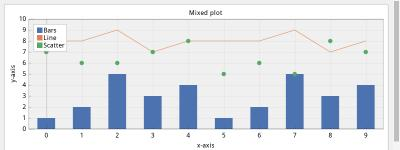

In [1]:
import imgui_bundle
from imgui_bundle import implot, imgui, imgui_knobs, immapp, immvision
from imgui_bundle.demos_python import demo_utils
import time

import numpy as np
import cv2

lin = np.array([8, 8, 9, 7, 8, 8, 8, 9, 7, 8])
bar = np.array([1, 2, 5, 3, 4, 1, 2, 5, 3, 4])
dot = np.array([7, 6, 6, 7, 8, 5, 6, 5, 8, 7])


def mixed_plot():
    imgui.style_colors_light()
    if implot.begin_plot("Mixed plot"):
        implot.setup_axes("x-axis", "y-axis")
        implot.setup_axes_limits(-0.5, 9.5, 0, 10)
        implot.plot_bars("Bars", bar, 0.5)
        implot.plot_line("Line", lin)
        implot.plot_scatter("Scatter", dot)
        implot.end_plot()


immapp.run(mixed_plot, window_size=(800, 300), with_implot=True, thumbnail_height=300)

# Another example with ImPlot (heart haiku) 

Glfw Error 65548: Cocoa: Regular windows do not have icons on macOS


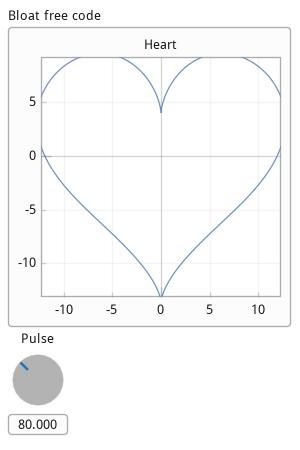

In [2]:
def haiku_heart():
    vals = np.arange(0, np.pi * 2, 0.01)
    x = np.power(np.sin(vals), 3) * 16
    y = (
        13 * np.cos(vals)
        - 5 * np.cos(2 * vals)
        - 2 * np.cos(3 * vals)
        - np.cos(4 * vals)
    )

    phase = 0
    t0 = time.time() + 0.2
    heart_pulse_rate = 80

    def gui():
        nonlocal heart_pulse_rate, phase, t0
        t = time.time()
        phase += (t - t0) * heart_pulse_rate / (np.pi * 2)
        k = 0.8 + 0.1 * np.cos(phase)
        t0 = t
        imgui.text("Bloat free code")
        implot.begin_plot("Heart")
        implot.plot_line("", x * k, y * k)
        implot.end_plot()
        _, heart_pulse_rate = imgui_knobs.knob("Pulse", heart_pulse_rate, 30, 180)

    immapp.run(gui, window_size=(300, 450), fps_idle=20, thumbnail_ratio=0.5, with_implot=True)


haiku_heart()

# An example with immvision.image

Adapted from an OpenCV example: https://docs.opencv.org/4.x/d5/db5/tutorial_laplace_operator.html

`immvision.image(label, image, params)` displays an image with an options panel giving extensive visualisation options.

In [3]:
from imgui_bundle import imgui, immapp, immvision
from imgui_bundle.demos_python import demo_utils
import cv2
import random as rng
import numpy as np
from numpy.typing import NDArray


# First, lets define `LaplacianData` (a class that contains an image and its laplacian)
class LaplacianData:
    src_gray: NDArray[float]
    laplacian: NDArray[float]

    blur_half_size: int = 1
    kernel_half_size: int = 1

    params: immvision.ImageParams

    def __init__(self, image_file: str):
        img = cv2.imread(image_file)
        img = cv2.resize(img, dsize=None, fx=0.5, fy=0.5)
        gray_uint8 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        self.src_gray = gray_uint8 / 255.0
        self.update_laplacian()

        self.params = immvision.ImageParams()
        self.params.image_display_size = (400, 0)
        self.params.show_options_panel = True

    def update_laplacian(self):
        ddepth = cv2.CV_64F
        blur_width = self.blur_half_size * 2 + 1
        kernel_size = self.kernel_half_size * 2 + 1
        blur = cv2.GaussianBlur(self.src_gray, (blur_width, blur_width), 0)
        self.laplacian = cv2.Laplacian(blur, ddepth, ksize=kernel_size)


# Then let's define `gui_laplacian` (a gui that display and manipulates LaplacianData)
def gui_laplacian(data: LaplacianData):
    changed1, data.blur_half_size = imgui.slider_int(
        "Blur half size", data.blur_half_size, 1, 10
    )
    changed2, data.kernel_half_size = imgui.slider_int(
        "Kernel half size", data.kernel_half_size, 1, 10
    )
    changed = changed1 or changed2
    if changed:
        data.update_laplacian()
    data.params.refresh_image = changed
    immvision.image("Laplacian", data.laplacian, data.params)


# Then, let's instantiate our LaplacianData
laplacian_data = LaplacianData(demo_utils.demos_assets_folder() + "/images/house.jpg")


# Finally, define a parameterless gui function from it
def my_gui_laplacian():
    gui_laplacian(laplacian_data)

Then, let's display and manipulate our laplacian. Since it is a float matrix, you can apply ColorMaps to it in the options panel

Glfw Error 65548: Cocoa: Regular windows do not have icons on macOS


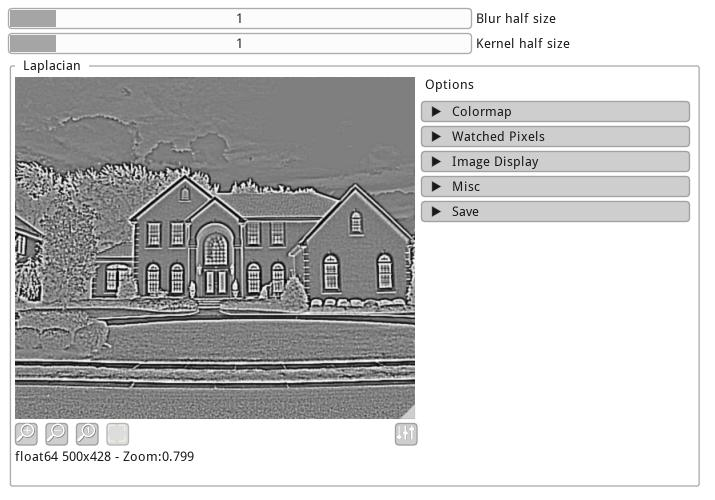

In [4]:
immapp.run(my_gui_laplacian, thumbnail_ratio=0.5)